In [95]:
import pandas as pd 
import numpy as np

import re

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install sagemaker==1.72.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Load data

In [96]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

## Analyze data

In [97]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Plot the distribution of target

From the plot, we see that the data is not imbalanced

<AxesSubplot:>

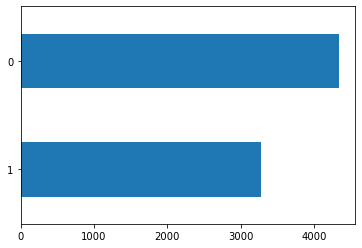

In [65]:
train_data.target.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:ylabel='Frequency'>

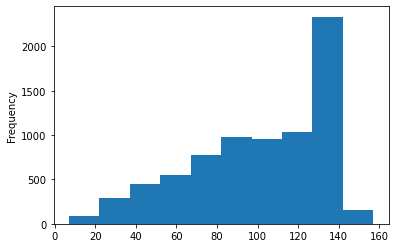

In [66]:
train_data["text_len"] = train_data.text.apply(lambda text:len(text))
train_data["text_len"].plot.hist()

## Clean data

In [98]:
def clean_text(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def review_to_words(review):
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    text = clean_text(text)
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = ' '.join([PorterStemmer().stem(w) for w in words]) # stem
    
    return words

In [99]:
train_data["clean_text"] = train_data["text"].apply(lambda row:review_to_words(row))
test_data["clean_text"] = test_data["text"].apply(lambda row:review_to_words(row))

## use TfidfTransformer to generate feature for test and train set

In [100]:
pipe = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer())])
train_feature = pipe.fit_transform(train_data["clean_text"]).toarray()
test_feature = pipe.transform(test_data["clean_text"] ).toarray()

print(train_feature.shape)

(7613, 15774)


## Save data to csv file and upload

In [101]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # Store the current SageMaker session
role = get_execution_role()

In [102]:
import os

data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## save data to csv file
pd.concat([train_data["target"],pd.DataFrame(train_feature)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.DataFrame(test_feature).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# upload to s3
prefix = 'predict-disaster'
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)


In [72]:
pd.DataFrame(train_feature).shape

(7613, 15774)

## Train the model with Pytorch

In [73]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

bucket = session.default_bucket()
# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)
input_dim = train_feature.shape[1]
# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='script', # this should be just "source" for your code
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=session,
                    hyperparameters={
                        'input_dim': input_dim,  # num of features
                        'hidden_dim': 40,
                        'output_dim': 1,
                        'epochs': 40 # could change to higher
                    })

In [80]:
# train the estimator on S3 training data
estimator.fit({'train': train_location})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-07-19 05:29:34 Starting - Starting the training job...
2021-07-19 05:29:36 Starting - Launching requested ML instances...
2021-07-19 05:30:31 Starting - Preparing the instances for training.........
2021-07-19 05:31:41 Downloading - Downloading input data...
2021-07-19 05:32:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-19 05:32:28,977 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-07-19 05:32:28,980 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-19 05:32:28,992 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-19 05:32:28,993 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-19 05:32:29,361 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup

Epoch: 38, Loss: 0.0164078849970907
Epoch: 39, Loss: 0.015594216015682939
Epoch: 40, Loss: 0.015007592612577156
Saving the model.
2021-07-19 05:34:43,080 sagemaker-containers INFO     Reporting training SUCCESS

2021-07-19 05:34:52 Uploading - Uploading generated training model
2021-07-19 05:34:52 Completed - Training job completed
Training seconds: 191
Billable seconds: 191


## Deploy model and predict data on test set

In [81]:
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='script')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [82]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!CPU times: user 444 ms, sys: 32.1 ms, total: 476 ms
Wall time: 8min 33s


In [91]:
prediction = [] #np.squeeze(np.round(predictor.predict(test_feature)))
for i in range(len(test_feature)):
    prediction.append((int(np.round(predictor.predict(test_feature[i]))[0])))

In [93]:
## output values as csv file
predict = pd.DataFrame(prediction)
predict["id"] = test_data["id"].values
predict["target"] = prediction
predict[["id","target"]].to_csv("predict.csv", index=False)

## Evaluation

The result is submitted to Kaggle, the score is 0.76677

## Clean resourses

In [94]:
predictor.delete_endpoint()

## Train model with xgboost

In [103]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [104]:
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)


xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [107]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
xgb.fit({'train': s3_input_train})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-07-19 14:39:22 Starting - Starting the training job...
2021-07-19 14:39:24 Starting - Launching requested ML instances...
2021-07-19 14:40:20 Starting - Preparing the instances for training.........
2021-07-19 14:41:50 Downloading - Downloading input data......
2021-07-19 14:42:30 Training - Downloading the training image..Arguments: train
[2021-07-19:14:42:58:INFO] Running standalone xgboost training.
[2021-07-19:14:42:58:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-07-19:14:42:58:INFO] File size need to be processed in the node: 459.25mb. Available memory size in the node: 8404.85mb
[2021-07-19:14:42:58:INFO] Determined delimiter of CSV input is ','
[14:42:58] S3DistributionType set as FullyReplicated
[14:43:01] 7613x15774 matrix with 120087462 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[14:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=5
[0]#011train-error:0.3567

[14:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[46]#011train-error:0.212268
[14:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[47]#011train-error:0.211218
[14:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[48]#011train-error:0.210167
[14:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[49]#011train-error:0.20951
[14:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[50]#011train-error:0.208591
[14:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=5
[51]#011train-error:0.207146
[14:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[52]#011train-error:0.205832
[14:44:57] sr

In [ ]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


................

In [ ]:
## output values as csv file
prediction = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
prediction = [round(num) for num in prediction.squeeze().values]

predict = pd.DataFrame(prediction)
predict["id"] = test_data["id"].values
predict["target"] = prediction
predict[["id","target"]].to_csv("predict_boostrap.csv", index=False)

## Evaluation

The result is submitted to Kaggle. The score is: 0.77474

## Conclusion

The result from xgboost is higher in this case. However, the result may change if we perform parameter tuning or change the layers in the pytorch model.